# ZFOURGE Observational Modelling and Fitting Analysis
This section is dedicated entirely to outputing the results from the ZFOURGE survey observational fitting, including creation of composite SED data. This involves some rudimentary fitting/analysis but nothing major. 

In [319]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath


# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [320]:
# Choose if you want to save the plots
save_figures = True
fig_size_params = (10, 6)

In [321]:
# We would like to investigate the effects of the different filters.
# Read in the dataframe

#field = 'COSMOS'
agn_model_name = 'Type2AGN'
template_set_name = 'ZFOURGE'

# read in the dataframe and ensure that the unamed: 0 column is the index
composite_choice = f'ZFOURGE_obsevational_composites_fluxes{agn_model_name}'
composite_fluxes = pd.read_csv(f'outputs\composite_seds\{composite_choice}.csv', index_col=0)   
# Drop the first col
#composite_fluxes = composite_fluxes.drop(columns=['Unnamed: 0.1'])

composite_fluxes.reset_index(drop=True, inplace=True)

In [322]:
# Check outputs
composite_fluxes

# Check index column 
len(composite_fluxes.index.unique())

1466

In [323]:
composite_fluxes['id'].duplicated().sum()

# drop the duplicates
composite_fluxes = composite_fluxes.drop_duplicates(subset='id')


In [324]:
# have a look at it now
composite_fluxes


,id,z,U_0,U_10,U_20,U_30,U_40,U_50,U_60,U_70,...,r_20,r_30,r_40,r_50,r_60,r_70,r_80,r_90,r_100,field
0,COSMOS_10044,0.7659,-20.571280,-20.571297,-20.571315,-20.571333,-20.571351,-20.571369,-20.571386,-20.571404,...,22.196792,22.196774,22.196756,22.196738,22.196720,22.196702,22.196684,22.196666,22.196648,COSMOS
1,COSMOS_10115,3.3686,-18.528297,-18.528312,-18.528326,-18.528341,-18.528355,-18.528369,-18.528384,-18.528398,...,27.379853,27.379850,27.379848,27.379845,27.379842,27.379840,27.379837,27.379834,27.379832,COSMOS
2,COSMOS_10203,1.3255,-19.708685,-19.708701,-19.708717,-19.708733,-19.708749,-19.708765,-19.708782,-19.708798,...,24.479931,24.479918,24.479904,24.479891,24.479877,24.479864,24.479851,24.479837,24.479824,COSMOS
3,COSMOS_10257,4.7496,-19.104466,-19.104479,-19.104493,-19.104506,-19.104519,-19.104533,-19.104546,-19.104559,...,28.986678,28.986670,28.986661,28.986653,28.986644,28.986636,28.986627,28.986619,28.986610,COSMOS
4,COSMOS_10309,3.3632,-19.863381,-19.863395,-19.863410,-19.863425,-19.863439,-19.863454,-19.863468,-19.863483,...,26.487688,26.487684,26.487679,26.487675,26.487671,26.487667,26.487663,26.487659,26.487655,COSMOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,CDFS_9863,3.0891,-18.157603,-18.157617,-18.157630,-18.157644,-18.157657,-18.157671,-18.157685,-18.157698,...,27.912156,27.912152,27.912148,27.912145,27.912141,27.912137,27.912133,27.912129,27.912125,CDFS
1462,CDFS_9875,4.2678,-17.686288,-17.686305,-17.686321,-17.686337,-17.686353,-17.686370,-17.686386,-17.686402,...,29.124334,29.124331,29.124327,29.124323,29.124319,29.124316,29.124312,29.124308,29.124304,CDFS
1463,CDFS_9883,3.7077,-18.822725,-18.822739,-18.822753,-18.822768,-18.822782,-18.822796,-18.822811,-18.822825,...,27.481249,27.481246,27.481243,27.481241,27.481238,27.481235,27.481232,27.481229,27.481227,CDFS
1464,CDFS_9930,3.5035,-19.494273,-19.494287,-19.494300,-19.494314,-19.494328,-19.494342,-19.494356,-19.494370,...,26.702341,26.702338,26.702335,26.702332,26.702329,26.702326,26.702323,26.702320,26.702317,CDFS


In [325]:
# Make some plots
# Plot the SEDs of the composite object
# Get the filters
filters = composite_fluxes.columns[2:]

# For the first filter, see how many variations there are
filter_choice = filters[0].split('_')[0]


# Get the variations
filter_variations = [filter for filter in filters if filter_choice in filter]

# add the alpha values to a new array
alpha_values = [int(filter.split('_')[1]) for filter in filter_variations]

# Print the alpha values
print(alpha_values)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [326]:
# Check the range of redshift values
composite_fluxes['z'].describe()


count    1466.000000
mean        2.523827
std         1.411590
min         0.113600
25%         1.240275
50%         2.540550
75%         3.742575
max         4.998200
Name: z, dtype: float64

## UVJ

1466
redshift_bin:  [0, 0.5]


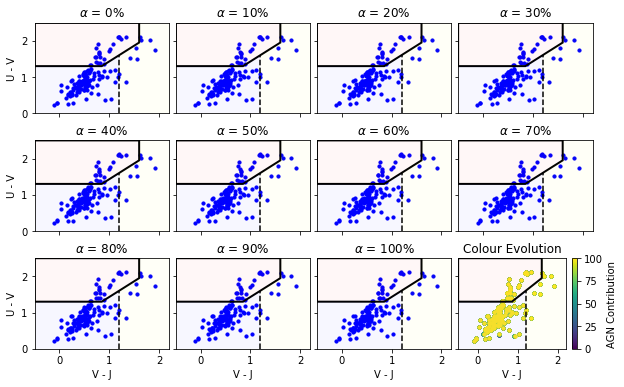

redshift_bin:  [0.5, 1]


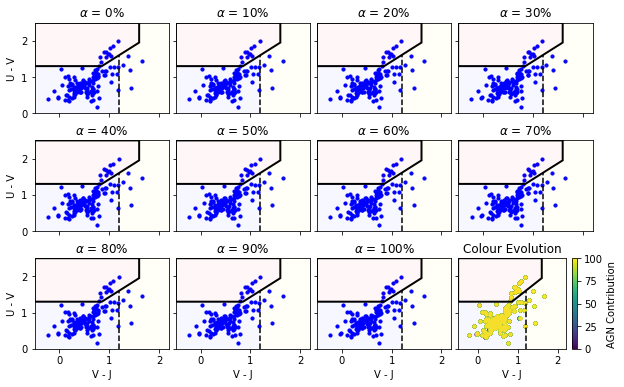

redshift_bin:  [1, 1.5]


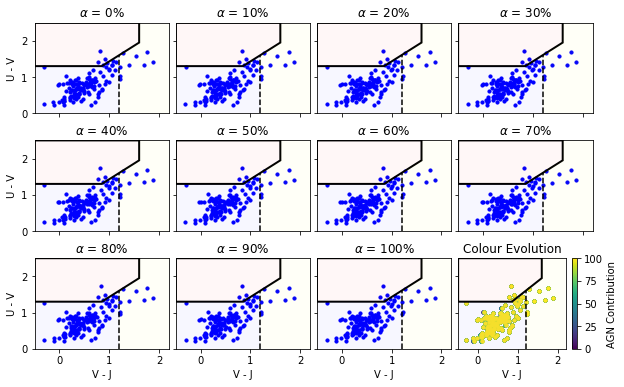

redshift_bin:  [1.5, 2]


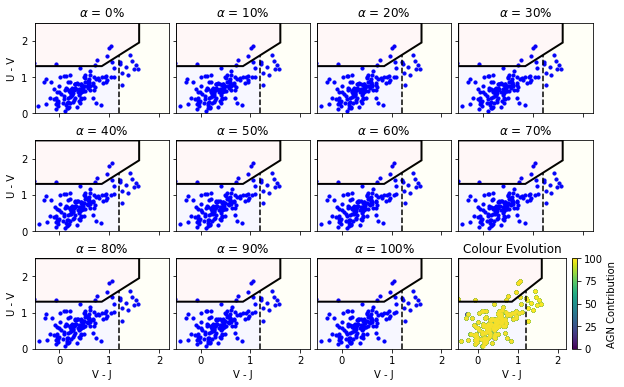

redshift_bin:  [2, 2.5]


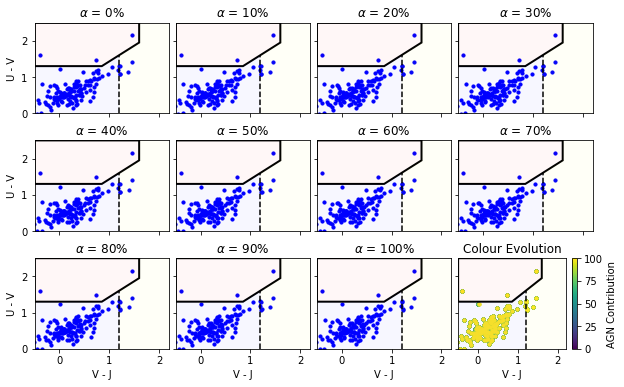

redshift_bin:  [2.5, 3]


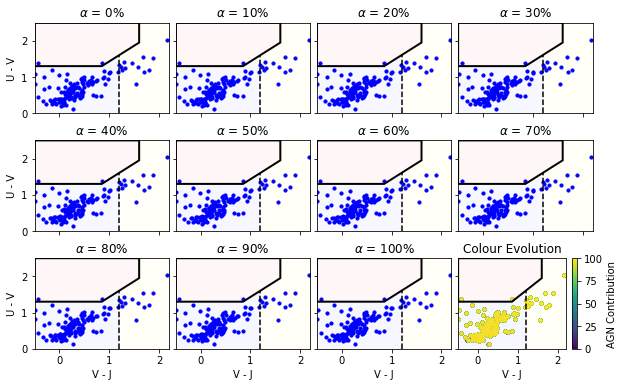

redshift_bin:  [3, 3.5]


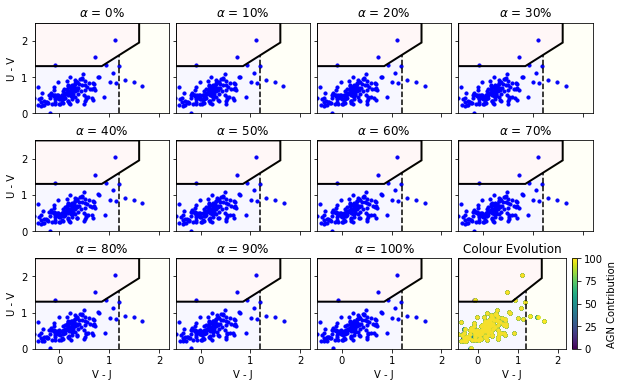

redshift_bin:  [3.5, 4]


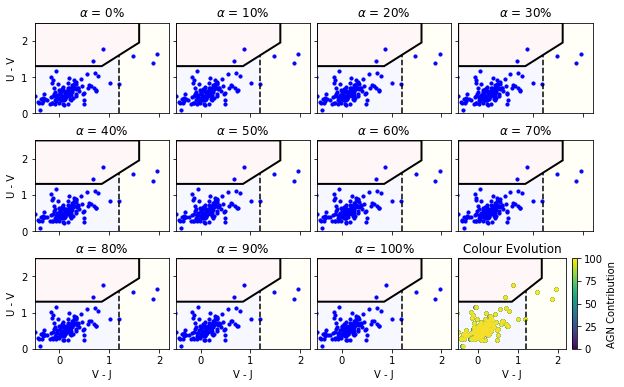

redshift_bin:  [4, 4.5]


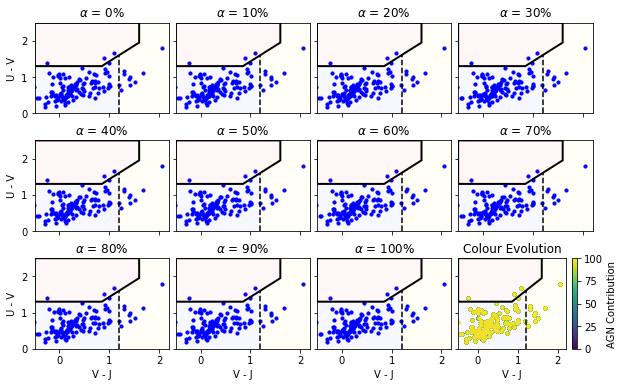

redshift_bin:  [4.5, 5]


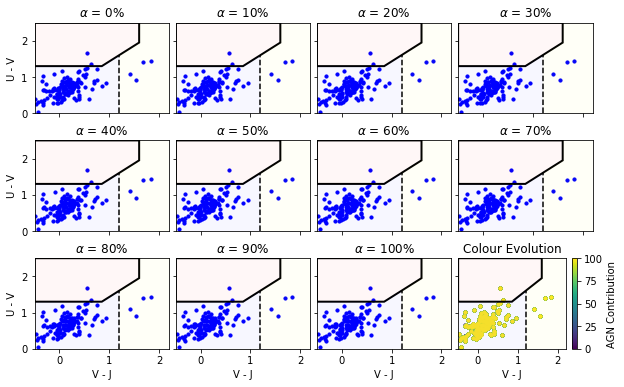

In [327]:
spacing = len(alpha_values)
colours_theme = plt.cm.viridis(np.linspace(0, 1, spacing))

# # Galaxy Fractions - Quiescent, Star-forming, Dusty for each alpha value
galaxy_fractions = {'Star-forming': [], 'Quiescent': [], 'Dusty': []} # each key will have a list of fractions for each alpha value
num_galaxies = len(composite_fluxes) # number of galaxies in the composite_flux in the rest frame

print(num_galaxies)

redshift_bins = [[0, 0.5], [0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 3.5], [3.5, 4], [4, 4.5], [4.5, 5]]

# For a single redshift bin output, change the bins 
#redshift_bins = [[0, 5]]

for redshift_bin in redshift_bins:
    lower_redshift_limit = redshift_bin[0]
    upper_redshift_limit = redshift_bin[1]

    subset_composite_fluxes = composite_fluxes[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] < upper_redshift_limit)].copy()

    print("redshift_bin: ", redshift_bin)


    fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
    for n in range(len(alpha_values)):
        # Get the filter magnitudes
        U_mag = subset_composite_fluxes[f'U_{alpha_values[n]}']
        V_mag = subset_composite_fluxes[f'V_{alpha_values[n]}']
        J_mag = subset_composite_fluxes[f'J_{alpha_values[n]}']
        
        # Create the colours
        uv = U_mag - V_mag
        vj = V_mag - J_mag
        
        # If the uv, and vj values don't exsist in this redshift bin, skip this bin
        if len(uv) == 0:
            break
        
        
        axs[n//4, n%4].scatter(vj, uv, c='blue', s=10)
        
        axs[n//4, n%4].set_xlim(-0.5, 2.2)
        axs[n//4, n%4].set_ylim(0, 2.5)
        
        # Plot AGN Contribution in the title 
        # alpha needs to be the alpha symbol
        #alpha_symbol = r'$\alpha$'
        axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
        
        # Define paths for selections
        path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
        path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
        path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]
        
        # Add patches for selections
        axs[n//4, n%4].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
        axs[n//4, n%4].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
        axs[n//4, n%4].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))
        
        # Add vertical line
        axs[n//4, n%4].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)
        
        # Add axis labels
        if n//4 == 2:
            axs[n//4, n%4].set_xlabel("V - J")
        if n%4 == 0:
            axs[n//4, n%4].set_ylabel("U - V")
            
        
        # We will obtain the Star-forming, Quiescent, and Dusty Fractions for this particular alpha value     
        # Obtain the number of galaxies with sf region dictated by the sf path
        # Create Path objects from your path coordinates (do this once, outside the loop)
        path_quiescent_obj = mpath.Path(path_quiescent)
        path_sf_obj = mpath.Path(path_sf)
        path_sfd_obj = mpath.Path(path_sfd)

        # Create a DataFrame with just the uv and vj columns for easier selection
        uvj_data = pd.DataFrame({'vj': vj, 'uv': uv})

        # Perform the selection
        quiescent_seds = uvj_data[path_quiescent_obj.contains_points(uvj_data.values)]
        sf_seds = uvj_data[path_sf_obj.contains_points(uvj_data.values)]
        sfd_seds = uvj_data[path_sfd_obj.contains_points(uvj_data.values)]
        

    for m in range(len(alpha_values)):
        # Get the filter magnitudes
        U_mag = subset_composite_fluxes[f'U_{alpha_values[m]}']
        V_mag = subset_composite_fluxes[f'V_{alpha_values[m]}']
        J_mag = subset_composite_fluxes [f'J_{alpha_values[m]}']
        
        # Create the colours
        uv = U_mag - V_mag
        vj = V_mag - J_mag
        

        # Plot scatter
        axs[2, 3].scatter(vj, uv, c=[colours_theme[m]], s=10)
        
        
    # Add patches for selections
    axs[2, 3].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
    axs[2, 3].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
    axs[2, 3].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

    # Add vertical line
    axs[2, 3].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

    # Add axis labels
    axs[2, 3].set_xlabel("V - J")

    # AGN Colour Evolution title
    axs[2, 3].set_title("Colour Evolution")

    # Plot colorbar for AGN contribution
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
    cbar = plt.colorbar(sm, ax=axs[2, 3])

    # Name the colorbar
    cbar.set_label('AGN Contribution')

        
    # Make the subplots closer together
    plt.subplots_adjust(wspace=0.05, hspace=0.3)
        

    # Save the output
    if save_figures:
        plt.savefig(f'outputs/ThesisPlots/UVJ_evolution_{agn_model_name}_ZFOURGE_{lower_redshift_limit}_{upper_redshift_limit}.png')

    # Show the output
    plt.show()


redshift_bin:  [0, 0.5]
redshift_bin:  [0.5, 1]
redshift_bin:  [1, 1.5]
redshift_bin:  [1.5, 2]
redshift_bin:  [2, 2.5]
redshift_bin:  [2.5, 3]
redshift_bin:  [3, 3.5]
redshift_bin:  [3.5, 4]
redshift_bin:  [4, 4.5]
redshift_bin:  [4.5, 5]


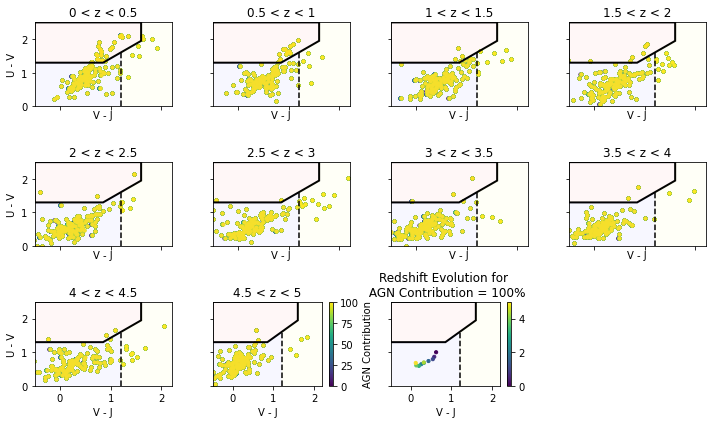

In [328]:
# Do the same as above but bin the redshifts instead of the alpha vals
redshift_bins = [[0, 0.5], [0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 3.5], [3.5, 4], [4, 4.5], [4.5, 5]]


average_redshift_colours = {'uv': [], 'vj': []}

# For a single redshift bin output, change the bins 
#redshift_bins = [[0, 5]]
fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
for n, redshift_bin in enumerate(redshift_bins):
    lower_redshift_limit = redshift_bin[0]
    upper_redshift_limit = redshift_bin[1]

    subset_composite_fluxes = composite_fluxes[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] < upper_redshift_limit)].copy()

    print("redshift_bin: ", redshift_bin)



    for m in range(len(alpha_values)):
        # Get the filter magnitudes
        U_mag = subset_composite_fluxes[f'U_{alpha_values[m]}']
        V_mag = subset_composite_fluxes[f'V_{alpha_values[m]}']
        J_mag = subset_composite_fluxes [f'J_{alpha_values[m]}']
        
        # Create the colours
        uv = U_mag - V_mag
        vj = V_mag - J_mag
        
        # Add the uv and vj values to the average_redshift_colours dictionary
        # only for the 100 AGN contribution
        if alpha_values[m] == 100:
            average_redshift_colours['uv'].append(np.mean(uv))
            average_redshift_colours['vj'].append(np.mean(vj))
        

        # Plot scatter
        axs[n//4, n%4].scatter(vj, uv, c=[colours_theme[m]], s=10)
        
        
        # Add axis labels
        if n//4 == 2:
            axs[n//4, n%4].set_xlabel("V - J")
        if n%4 == 0:
            axs[n//4, n%4].set_ylabel("U - V")
            
        
        
        
        # We will obtain the Star-forming, Quiescent, and Dusty Fractions for this particular alpha value     
        # Obtain the number of galaxies with sf region dictated by the sf path
        # Create Path objects from your path coordinates (do this once, outside the loop)
        path_quiescent_obj = mpath.Path(path_quiescent)
        path_sf_obj = mpath.Path(path_sf)
        path_sfd_obj = mpath.Path(path_sfd)

        # Create a DataFrame with just the uv and vj columns for easier selection
        uvj_data = pd.DataFrame({'vj': vj, 'uv': uv})

        # Perform the selection
        quiescent_seds = uvj_data[path_quiescent_obj.contains_points(uvj_data.values)]
        sf_seds = uvj_data[path_sf_obj.contains_points(uvj_data.values)]
        sfd_seds = uvj_data[path_sfd_obj.contains_points(uvj_data.values)]
        
        # Add patches for selections
    axs[n//4, n%4].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
    axs[n//4, n%4].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
    axs[n//4, n%4].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

    # Add vertical line
    axs[n//4, n%4].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

    # Add axis labels
    axs[n//4, n%4].set_xlabel("V - J")

    # AGN Colour Evolution title - just call it redshift
    axs[n//4, n%4].set_title(f"{lower_redshift_limit} < z < {upper_redshift_limit}")
    
    # Ensure limits
    axs[n//4, n%4].set_xlim(-0.5, 2.2)
    axs[n//4, n%4].set_ylim(0, 2.5)
    

    # # Plot colorbar for AGN contribution
    # sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
    # cbar = plt.colorbar(sm, ax=axs[n//4, n%4])

    # # Name the colorbar
    # cbar.set_label('AGN Contribution')

    # Plot one colourbar down the bottom where the other subplots should have been
    if n == len(redshift_bins) - 1:
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
        cbar = plt.colorbar(sm, ax=axs[n//4, n%4])

        # Name the colorbar
        cbar.set_label('AGN Contribution')
        
        
    # for m in range(len(alpha_values)):
    #     # Get the filter magnitudes
    #     U_mag = subset_composite_fluxes[f'U_{alpha_values[m]}']
    #     V_mag = subset_composite_fluxes[f'V_{alpha_values[m]}']
    #     J_mag = subset_composite_fluxes [f'J_{alpha_values[m]}']
        
    #     # Create the colours
    #     uv = U_mag - V_mag
    #     vj = V_mag - J_mag
        

    #     # Plot scatter
    #     axs[2, 3].scatter(vj, uv, c=[colours_theme[m]], s=10)
    
    # In the last subplot axs 2, 2 
    # calc the average position of the final uv vj colours (at AGN contribution 100) and plot it's progression in colour space
    
    
    
# Create the colours
uv = average_redshift_colours['uv']
vj = average_redshift_colours['vj']

# Create the redshift bins
redshift_bins = np.array(redshift_bins)
colors = np.linspace(0, 1, len(redshift_bins))


# Plot scatter
axs[2, 2].scatter(vj, uv, c=colors, s=10)

#  Set 

# Add patches for selections
axs[2, 2].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
axs[2, 2].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
axs[2, 2].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
axs[2, 2].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Add axis labels
axs[2, 2].set_xlabel("V - J")

# AGN Colour Evolution title
axs[2, 2].set_title("Redshift Evolution for \n AGN Contribution = 100%")

# Plot colorbar for AGN contribution
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=5))
cbar = plt.colorbar(sm, ax=axs[2, 2])

    
        
    

            
        # Make the subplots closer together
# plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.tight_layout()

# Delete the last two subplots
fig.delaxes(axs[2, 3])


# Save 
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/UVJ_redshift_agn_evolution_{agn_model_name}_ZFOURGE.png')

plt.show()



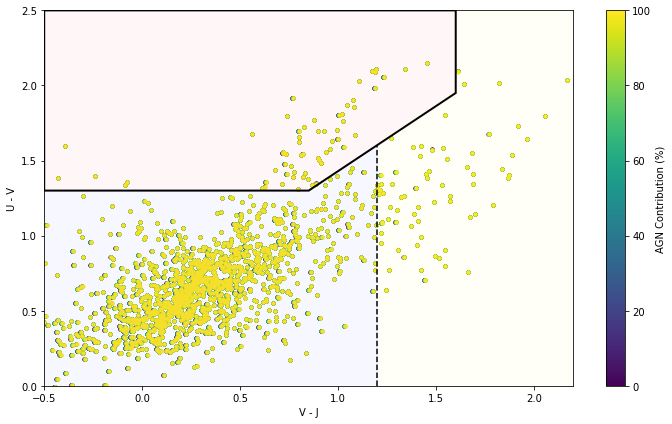

In [329]:
# Maybe just plot an all redshift UVJ diagram 
fig, axs = plt.subplots(1, 1, figsize=fig_size_params, sharex=True, sharey=True)



for m in range(len(alpha_values)):
    # Get the filter magnitudes
    U_mag = composite_fluxes[f'U_{alpha_values[m]}']
    V_mag = composite_fluxes[f'V_{alpha_values[m]}']
    J_mag = composite_fluxes[f'J_{alpha_values[m]}']
    
    # Create the colours
    uv = U_mag - V_mag
    vj = V_mag - J_mag
    
    # Add the uv and vj values to the average_redshift_colours dictionary
    # only for the 100 AGN contribution

    # Plot scatter
    axs.scatter(vj, uv, c=[colours_theme[m]], s=10)
    

        
    
    
    
    # We will obtain the Star-forming, Quiescent, and Dusty Fractions for this particular alpha value     
    # Obtain the number of galaxies with sf region dictated by the sf path
    # Create Path objects from your path coordinates (do this once, outside the loop)
    path_quiescent_obj = mpath.Path(path_quiescent)
    path_sf_obj = mpath.Path(path_sf)
    path_sfd_obj = mpath.Path(path_sfd)

    # Create a DataFrame with just the uv and vj columns for easier selection
    uvj_data = pd.DataFrame({'vj': vj, 'uv': uv})

    # Perform the selection
    quiescent_seds = uvj_data[path_quiescent_obj.contains_points(uvj_data.values)]
    sf_seds = uvj_data[path_sf_obj.contains_points(uvj_data.values)]
    sfd_seds = uvj_data[path_sfd_obj.contains_points(uvj_data.values)]
    
    # Calculate the fractions
    galaxy_fractions['Quiescent'].append(len(quiescent_seds) / num_galaxies)
    galaxy_fractions['Star-forming'].append(len(sf_seds) / num_galaxies)
    galaxy_fractions['Dusty'].append(len(sfd_seds) / num_galaxies)
    
    
    # Add patches for selections
axs.add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
axs.add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
axs.add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
axs.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Add axis labels
axs.set_xlabel("V - J")
axs.set_ylabel("U - V")


# AGN Colour Evolution title - just call it redshift
# axs.set_title(f"Colour Evolution for ZFOURGE Composites")

# Ensure limits
axs.set_xlim(-0.5, 2.2)
axs.set_ylim(0, 2.5)
    # Make the subplots closer together
# plt.subplots_adjust(wspace=0.05, hspace=0.3)

# Add a colourbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs)

# Name the colorbar
cbar.set_label('AGN Contribution (%)')


plt.tight_layout()




# Save 
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/UVJ_agn_evolution_{agn_model_name}_ZFOURGE.png')

plt.show()



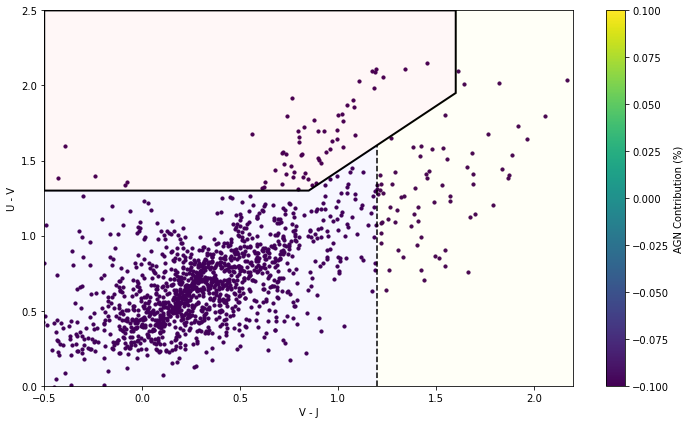

In [330]:
# Maybe just plot an all redshift UVJ diagram 
fig, axs = plt.subplots(1, 1, figsize=fig_size_params, sharex=True, sharey=True)


alpha_values = [0]
for m in range(len(alpha_values)):
    # Get the filter magnitudes
    U_mag = composite_fluxes[f'U_{alpha_values[m]}']
    V_mag = composite_fluxes[f'V_{alpha_values[m]}']
    J_mag = composite_fluxes[f'J_{alpha_values[m]}']
    
    # Create the colours
    uv = U_mag - V_mag
    vj = V_mag - J_mag
    
    # Add the uv and vj values to the average_redshift_colours dictionary
    # only for the 100 AGN contribution

    # Plot scatter
    axs.scatter(vj, uv, c=[colours_theme[m]], s=10)
    

        
    
    
    
    # We will obtain the Star-forming, Quiescent, and Dusty Fractions for this particular alpha value     
    # Obtain the number of galaxies with sf region dictated by the sf path
    # Create Path objects from your path coordinates (do this once, outside the loop)
    path_quiescent_obj = mpath.Path(path_quiescent)
    path_sf_obj = mpath.Path(path_sf)
    path_sfd_obj = mpath.Path(path_sfd)

    # Create a DataFrame with just the uv and vj columns for easier selection
    uvj_data = pd.DataFrame({'vj': vj, 'uv': uv})

    # Perform the selection
    quiescent_seds = uvj_data[path_quiescent_obj.contains_points(uvj_data.values)]
    sf_seds = uvj_data[path_sf_obj.contains_points(uvj_data.values)]
    sfd_seds = uvj_data[path_sfd_obj.contains_points(uvj_data.values)]
    
    # Calculate the fractions
    galaxy_fractions['Quiescent'].append(len(quiescent_seds) / num_galaxies)
    galaxy_fractions['Star-forming'].append(len(sf_seds) / num_galaxies)
    galaxy_fractions['Dusty'].append(len(sfd_seds) / num_galaxies)
    
    
    # Add patches for selections
axs.add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
axs.add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
axs.add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
axs.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Add axis labels
axs.set_xlabel("V - J")
axs.set_ylabel("U - V")


# AGN Colour Evolution title - just call it redshift
# axs.set_title(f"Colour Evolution for ZFOURGE Composites")

# Ensure limits
axs.set_xlim(-0.5, 2.2)
axs.set_ylim(0, 2.5)
    # Make the subplots closer together
# plt.subplots_adjust(wspace=0.05, hspace=0.3)

# Add a colourbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs)

# Name the colorbar
cbar.set_label('AGN Contribution (%)')


plt.tight_layout()




# Save 
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/UVJ_{agn_model_name}_ZFOURGE_all.png')

plt.show()
alpha_values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

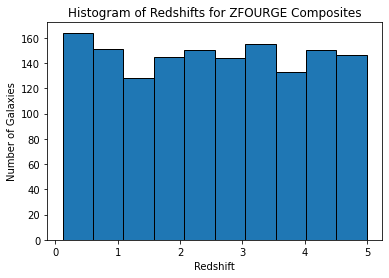

In [331]:
# Print the histogram of the redshifts
plt.hist(composite_fluxes['z'], bins=10, edgecolor='black')
plt.xlabel('Redshift')
plt.ylabel('Number of Galaxies')
plt.title('Histogram of Redshifts for ZFOURGE Composites')
plt.show()


In [332]:
# # Check the fractions 
galaxy_fractions

fraction_figsize = (3, 4)
# Plot the fractions
fig, ax = plt.subplots(figsize=fraction_figsize)
ax.plot(alpha_values, galaxy_fractions['Quiescent'], label='Quiescent', color='red')
ax.plot(alpha_values, galaxy_fractions['Star-forming'], label='Star-forming', color='blue')
ax.plot(alpha_values, galaxy_fractions['Dusty'], label='Dusty', color='Green')

# Add labels
ax.set_xlabel(f'AGN Contribution (%)')
ax.set_ylabel('Fraction')
#ax.set_title('Fraction of Galaxies in UVJ Diagram')
ax.legend()

# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/UVJ_galfractions_{agn_model_name}_{template_set_name}.png')
    
# Show the output
plt.show()

# Also convert the fractions to a dataframe
galaxy_fractions_df = pd.DataFrame(galaxy_fractions, index=alpha_values)



if save_figures:
    galaxy_fractions_df.to_csv(f'outputs/ThesisPlots/UVJ_fractions_{agn_model_name}_{template_set_name}.csv')

galaxy_fractions_df

ValueError: x and y must have same first dimension, but have shapes (11,) and (12,)

# ugr


<ipython-input-333-24918cb92f96>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_seds['redshift'] = redshifts_selected
<ipython-input-333-24918cb92f96>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_selected_seds['redshift'] = redshifts_non_selected
<ipython-input-333-24918cb92f96>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

count    1466.000000
mean        2.523827
std         1.411590
min         0.113600
25%         1.240275
50%         2.540550
75%         3.742575
max         4.998200
Name: z, dtype: float64
Correct Identification: 176
Correct Non-UGR Identification: 1131
Misidentification: 70
Missed Selection: 89
Correct Identification: 176
Correct Non-UGR Identification: 1131
Misidentification: 70
Missed Selection: 89
Correct Identification: 176
Correct Non-UGR Identification: 1131
Misidentification: 70
Missed Selection: 89
Correct Identification: 176
Correct Non-UGR Identification: 1131
Misidentification: 70
Missed Selection: 89
Correct Identification: 176
Correct Non-UGR Identification: 1131
Misidentification: 70
Missed Selection: 89
Correct Identification: 176
Correct Non-UGR Identification: 1131
Misidentification: 70
Missed Selection: 89
Correct Identification: 176
Correct Non-UGR Identification: 1131
Misidentification: 70
Missed Selection: 89
Correct Identification: 176
Correct Non-UGR Identifi

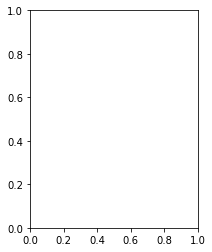

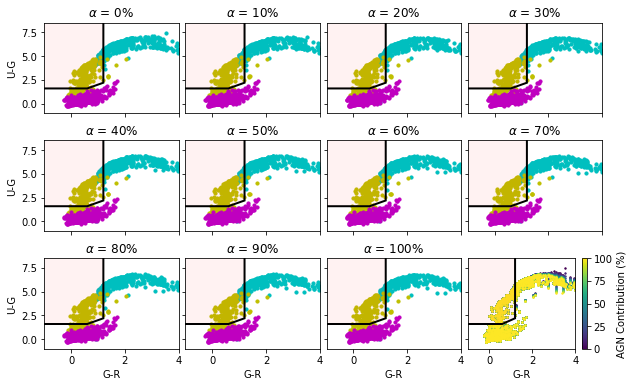

In [333]:
# ugr Diagram
fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
# have a look at the distibution for the composite_fluxes
print(composite_fluxes['z'].describe())


selection_statistics = {'Missed Selection': [], 'Misidentification': [], 'Correct Identification': [], 'Correct Non-UGR Identification': []}
# Realistically we are only interested in the correct identification and missed selection, but we will include all.
num_galaxies = len(composite_fluxes) # Because we consider all redshit ranges

# Completeness and contamination table
completeness_stats = {'Completeness': [] }


for n in range(len(alpha_values)):
    # Get the u, g, and r magnitudes for the specific alpha value
    u_col_name = f'u_{int(round(alpha_values[n], 2))}'
    g_col_name = f'g_{int(round(alpha_values[n], 2))}'
    r_col_name = f'r_{int(round(alpha_values[n], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]

    # Scatter plots with color-coded redshift ranges
    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               ug_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               c="c", s=10, label="z > 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               ug_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               c="y", s=10, label="2.6 < z < 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               ug_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               c="m", s=10, label="z < 2.6")
    
    
    # Set the AGN Contribution title 
    axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
    
    plt.xlabel("")
    plt.ylabel("")
    #plt.title("UGR Diagram for SED Templates at Different Redshifts(0 < z < 4) for alpha = {}".format(alphas[n]))

      
    # Set the axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("G-R")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("U-G")
    
    
    # add the alpha value information onto the plot somewhere
    #axs[n//4, n%4].text(0.5, 0.9, f"alpha = {round(alpha[n], 2)}", horizontalalignment='center', verticalalignment='center', transform=axs[n//4, n%4].transAxes)

    # Additionally we can plot the UGR selection criteria on the UGR diagram
    U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
    axs[n//4, n%4].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique
    
    
    # The path here is the UGR selection criteria, we can find the selected points in this particular population using the path
    # Create Path objects from your path coordinates (do this once, outside the loop)
    path = mpath.Path(U_rule)
    
    # Create a DataFrame with just the u-g and g-r columns for easier selection
    ugr_data = pd.DataFrame({'gr': gr_specific_alpha_colours, 'ug': ug_specific_alpha_colours})
    
    # append the associated redshifts to the ugr data
    redshifts = composite_fluxes['z']
    
    # Selection stats go here:
    # Perform the selection
    selected_seds = ugr_data[path.contains_points(ugr_data.values)]
    non_selected_seds = ugr_data[~path.contains_points(ugr_data.values)]
    
    # Using the id of the selected seds, we can find the associated redshift values
    redshifts_selected = redshifts[selected_seds.index]
    redshifts_non_selected = redshifts[non_selected_seds.index]
    
    # We can then append the redshifts to the selected seds
    selected_seds['redshift'] = redshifts_selected
    non_selected_seds['redshift'] = redshifts_non_selected
    
    # using the above data we can calculate the fractions
    correct_ugr_selection = selected_seds[(selected_seds['redshift'] >= 2.6) & (selected_seds['redshift'] <= 3.5)]
    correct_nonugr_selection = non_selected_seds[(non_selected_seds['redshift'] < 2.6) | (non_selected_seds['redshift'] > 3.5)]
    
    # Combine the above to be a correct identification
    #correct_identification = correct_ugr_selection.append(correct_nonugr_selection)
    
    # Misidentification - a selected sed that was not in the redshift range we were after - incorrect redshift range
    misidentification = selected_seds[(selected_seds['redshift'] < 2.6) | (selected_seds['redshift'] > 3.5)]
    
    # Missed Selection - a non-selected sed SED that was in the redshift range we were after, something we missed.
    missed_selection = non_selected_seds[(non_selected_seds['redshift'] >= 2.6) & (non_selected_seds['redshift'] <= 3.5)]
    
    
    # Print the numbers without the fractions
    print(f"Correct Identification: {len(correct_ugr_selection)}")
    print(f"Correct Non-UGR Identification: {len(correct_nonugr_selection)}")
    print(f"Misidentification: {len(misidentification)}")
    print(f"Missed Selection: {len(missed_selection)}")
    
    
    
    
    # # Calculate the fractions
    # selection_statistics['Correct Identification'].append(len(correct_ugr_selection) / num_galaxies)
    # selection_statistics['Correct Non-UGR Identification'].append(len(correct_nonugr_selection) / num_galaxies)
    # selection_statistics['Misidentification'].append(len(misidentification) / num_galaxies)
    # selection_statistics['Missed Selection'].append(len(missed_selection) / num_galaxies)
    
    # Instead of fractions, we can just append the numbers
    selection_statistics['Correct Identification'].append(len(correct_ugr_selection))
    selection_statistics['Correct Non-UGR Identification'].append(len(correct_nonugr_selection))
    selection_statistics['Misidentification'].append(len(misidentification))
    selection_statistics['Missed Selection'].append(len(missed_selection))
    
    # We can also quantify the completeness and contamination of the selection
    # Completeness = Correct Identification / (Correct Identification + Missed Selection)
    # Contamination = Misidentification / (Correct Identification + Misidentification)
    
    completeness = len(correct_ugr_selection) / (len(correct_ugr_selection) + len(missed_selection))
    #contamination = len(misidentification) / (len(correct_ugr_selection) + len(misidentification))
    
    # Append the values
    completeness_stats['Completeness'].append(completeness)
    
    
    
    
    
    axs[n//4, n%4].set_xlim(-1, 4)
    axs[n//4, n%4].set_ylim(-1, 8.5)
    
    
for m in range(len(alpha_values)):
    
    
    
    # Recall that this is only a restframe diagram, so only look at the restframe colours
    u_col_name = f'u_{int(round(alpha_values[m], 2))}'
    g_col_name = f'g_{int(round(alpha_values[m], 2))}'
    r_col_name = f'r_{int(round(alpha_values[m], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]
    
    # Scatter plots with color-coded redshift ranges
    axs[2, 3].scatter(gr_specific_alpha_colours, 
                               ug_specific_alpha_colours, 
                               c=colours_theme[m], s=2)


    
    
    # In addition we can plot a mean position for on each of the alpha plots. This mean value will be the mean of the ugr

# Additionally we can plot the UGR selection criteria on the UGR diagram
U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
axs[2, 3].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique

axs[2, 3].set_xlim(-1, 4)
axs[2, 3].set_ylim(-1, 8.5)

axs[2, 3].set_xlabel("G-R")


sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[2, 3])

# Add the AGN Contribution label
cbar.set_label('AGN Contribution (%)')

    
    
    # Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)
    

# if save_figures:
#     plt.savefig(f'outputs/ThesisPlots/ugr_evolution_{agn_model_name}_{template_set_name}.png')
    
# Plot
plt.show()

# As i don't have any extra redshift information this is accurately producing the right redshift information
# While there is limited redshift information, this does seem to be showing somewhat correct identification for low redshifts.

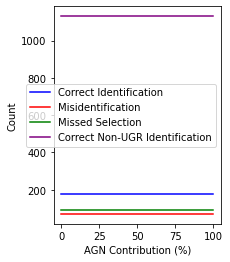

In [334]:
selection_statistics_df = pd.DataFrame(selection_statistics, index=alpha_values)

# Plot the fractions
fig, ax = plt.subplots(figsize=(3, 4))
ax.plot(alpha_values, selection_statistics['Correct Identification'], label='Correct Identification', color='blue')
ax.plot(alpha_values, selection_statistics['Misidentification'], label='Misidentification', color='red')
ax.plot(alpha_values, selection_statistics['Missed Selection'], label='Missed Selection', color='green')
ax.plot(alpha_values, selection_statistics['Correct Non-UGR Identification'], label='Correct Non-UGR Identification', color='purple')

# Add labels
ax.set_xlabel(f'AGN Contribution (%)')
ax.set_ylabel('Count')
#ax.set_title('Fraction of Galaxies in UGR Diagram')
ax.legend()

# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/ugr_selection_fractions_{agn_model_name}_{template_set_name}.png')
    
# Show the output
plt.show()

selection_statistics_df

# We would like to output the selection statistics to a csv file
if save_figures:
    selection_statistics_df.to_csv(f'outputs/ThesisPlots/ugr_selection_fractions_{agn_model_name}_{template_set_name}.csv')
    

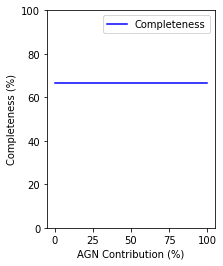

In [335]:
# Also plot the completeness and contamination statistics for each alpha
completeness_stats_df = pd.DataFrame(completeness_stats, index=alpha_values)

# add new column for completeness (convert to percentages)
completeness_stats_df['Completeness (%)'] = completeness_stats_df['Completeness'] * 100

# Plot the fractions
fig, ax = plt.subplots(figsize=(3, 4))

# Plot the completeness percentages
ax.plot(alpha_values, completeness_stats_df['Completeness (%)'], label='Completeness', color='blue')

# Add labels
ax.set_xlabel(f'AGN Contribution (%)')
ax.set_ylabel('Completeness (%)')
#ax.set_title('Fraction of Galaxies in UGR Diagram')
ax.legend()


# Set the ylim to 100
ax.set_ylim(0, 100)

# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/ugr_completeness_contamination_{agn_model_name}_{template_set_name}.png')
    
# Show the output
plt.show()

completeness_stats_df

# change the index to a column named alpha
# Create new column for alpha
completeness_stats_df['AGN Contribution (%)'] = completeness_stats_df.index
completeness_stats_df.reset_index(inplace=False).copy()

# Save the completeness percentages and AGN contribution to a csv file
if save_figures:
    completeness_stats_df[['AGN Contribution (%)', 'Completeness (%)']].to_csv(f'outputs/ThesisPlots/ugr_completeness_Contribution_{agn_model_name}_{template_set_name}.csv')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

ug_specific_alpha_colours:  3       5.274530
8       5.780259
18      4.608120
25      6.144036
26      6.696420
          ...   
1460    6.187378
1462    6.062545
1463    5.464791
1464    4.352530
1465    5.895070
Length: 447, dtype: float64
gr_specific_alpha_colours:  0       0.383401
1       0.547209
2       0.104920
3       4.529543
4       0.808455
          ...   
1461    0.081798
1462    2.475931
1463    1.129172
1464    0.846860
1465    3.388426
Length: 1466, dtype: float64


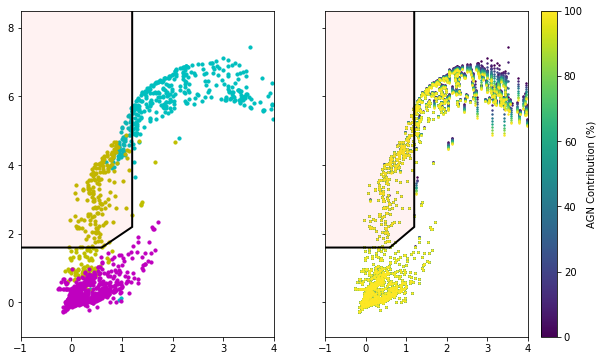

In [336]:
#
spacing = len(alpha_values)
colours_theme = plt.cm.viridis(np.linspace(0, 1, spacing))

# Do a double plot just for the last 
fig, axs = plt.subplots(1, 2, figsize=fig_size_params, sharex=True, sharey=True)

# # Get the u, g, and r magnitudes for the specific alpha value

u_col_name = f'u_{int(round(alpha_values[0], 2))}'
g_col_name = f'g_{int(round(alpha_values[0], 2))}'
r_col_name = f'r_{int(round(alpha_values[0], 2))}'

# Create the colours for the UGR diagram
ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]


print("ug_specific_alpha_colours: ", ug_specific_alpha_colours[composite_fluxes['z'] > 3.5])
print("gr_specific_alpha_colours: ", gr_specific_alpha_colours)


# Scatter plots with color-coded redshift ranges
axs[0].scatter(gr_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                            ug_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                            c="c", s=10, label="z > 3.5")

axs[0].scatter(gr_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                            ug_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                            c="y", s=10, label="2.6 < z < 3.5")

axs[0].scatter(gr_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                            ug_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                            c="m", s=10, label="z < 2.6")


colours_theme = plt.cm.viridis(np.linspace(0, 1, len(alpha_values)))


# Plot the colour evolution
for n in range(len(alpha_values)):
    # # Get the u, g, and r magnitudes for the specific alpha value
    
 # Recall that this is only a restframe diagram, so only look at the restframe colours
    u_col_name = f'u_{int(round(alpha_values[n], 2))}'
    g_col_name = f'g_{int(round(alpha_values[n], 2))}'
    r_col_name = f'r_{int(round(alpha_values[n], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]
    
    # Scatter plots with color-coded redshift ranges
    axs[1].scatter(gr_specific_alpha_colours, 
                               ug_specific_alpha_colours, 
                               c=colours_theme[n], s=2)



# Set the AGN Contribution title
#axs[0].set_title('')



plt.xlabel("")
plt.ylabel("")
#plt.title("UGR Diagram for SED Templates at Different Redshifts(0 < z < 4) for alpha = {}".format(alphas[n]))

# Add colourbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[1])

# Name the colorbar
cbar.set_label('AGN Contribution (%)')



# add the alpha value information onto the plot somewhere
#axs[n//4, n%4].text(0.5, 0.9, f"alpha = {round(alpha[n], 2)}", horizontalalignment='center', verticalalignment='center', transform=axs[n//4, n%4].transAxes)

# Additionally we can plot the UGR selection criteria on the UGR diagram
U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]

# Add patch to correct plot
axs[0].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout


# Add patch to correct plot
axs[1].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout


# The path here is the UGR selection criteria, we can find the selected points in this particular population using the path
# Create Path objects from your path coordinates (do this once, outside the loop)
path = mpath.Path(U_rule)

# Create a DataFrame with just the u-g and g-r columns for easier selection
ugr_data = pd.DataFrame({'gr': gr_specific_alpha_colours, 'ug': ug_specific_alpha_colours})

# append the associated redshifts to the ugr data
redshifts = composite_fluxes['z']

# Set limits
plt.xlim(-1, 4)
plt.ylim(-1, 8.5)

# Save
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/ugr_evolution_{agn_model_name}_ZFOURGE_comparison.png')

plt.show()

# IRAC 

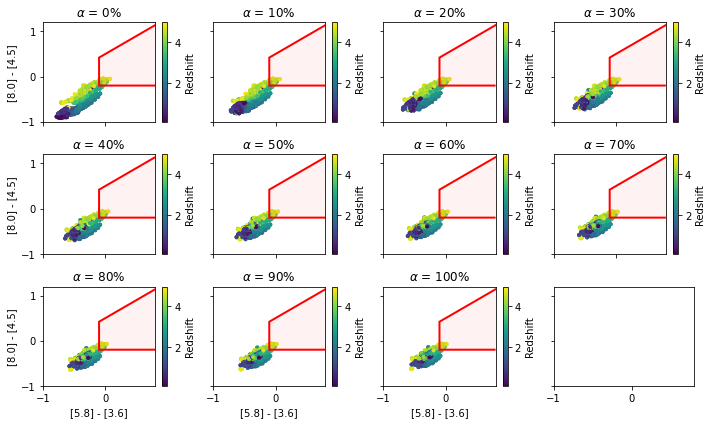

In [311]:
# Choose the diagram min and max
xmax = 0.8
ymax = 1.2
xmin = -1
ymin = -1

# Can change this to ensure we are only looking at the rest frame stuff
upper_redshift_limit = 0
lower_redshift_limit = 3.9

# setup 
fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
for n in range(len(alpha_values)):
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[n]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[n]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[n]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[n]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)

    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    
    
    # x = x[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    # y = y[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    
    
    
    # Reimplement the selection criteria 
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    
    # Colour code for each alpha - colour by redshift
    axs[n//4, n%4].scatter(x, y, c=composite_fluxes['z'], cmap='viridis', s=10)
    
    # Put a colour bar on the plot
    cbar = plt.colorbar(axs[n//4, n%4].scatter(x, y, c=composite_fluxes['z'], cmap='viridis', s=10), ax=axs[n//4, n%4])
    cbar.set_label('Redshift')
    
    # axs[n//4, n%4].scatter(x[lacy_selection_condition], y[lacy_selection_condition], c='blue', s=10)
    # axs[n//4, n%4].scatter(x[~lacy_selection_condition], y[~lacy_selection_condition], c='grey', s=10)
    
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[0]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[0]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[0]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[0]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)
    
    
    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    # # Ensure we are only looking at the rest frame stuff
    # x = x[composite_fluxes['z'] == 0]
    # y = y[composite_fluxes['z'] == 0]

    # # Reimplement the selection criteria
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    wedge_vertices = [
        (xmax, -0.2),
        (-0.1, -0.2),
        (-0.1, 0.8*-0.1 + 0.5 ),  # Handle empty selection
        (((ymax-0.5)/0.8), ymax)
    ] 
    wedge_polygon = plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor=(1,0,0,0.05), linestyle='-', linewidth=2, label='Lacy Wedge')
    # Plot the polygon on the subplot
    axs[n//4, n%4].add_patch(wedge_polygon)
    
    
    # Set the AGN Contribution title
    axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
    
    # Set the axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("[5.8] - [3.6]")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("[8.0] - [4.5]")
    
    # Set the axis limits
    axs[n//4, n%4].set_xlim(xmin, xmax)
    axs[n//4, n%4].set_ylim(ymin, ymax)
    
    
        
        
# Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)

plt.tight_layout()
# # Save the output
# if save_figures:
    
#     plt.savefig(f'outputs/ThesisPlots/IRAC_evolution_{agn_model_name}_{template_set_name}.png')


# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/IRAC_evolution_{agn_model_name}_ZFOURGE.png')
      
# Show the output
plt.show()

# These may not be appropriate for the redshifts that we are looking at, as we are looking at the rest frame values
# May have to look back at the drawing board and explore these in greater detail at a later date.



In [312]:
# Test completeness
# we will need to create a list of dictionaries
completeness_values = []

for n in range(len(alpha_values)):
    # at this alpha value, get the coordoinates
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[n]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[n]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[n]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[n]}']

    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)

    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours


    print(len(x))
    # # Reimplement the selection criteria
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    
    num_sources_selected = x[lacy_selection_condition].notna().sum()
    
    print(num_sources_selected)
    # get the number of sources that are selected by the lacy wedge
    # num_sources_selected = len()
    # print(num_sources_selected)
    # for the first value of alpha there will be no relevance as there are no AGN, 
    # but we can instead check how many of all sources were selected
    if n == 0:
        num_sources_all = len(x)
        completeness = num_sources_selected/num_sources_all
        completeness_values.append({'alpha': alpha_values[n], 'completeness': completeness})
    else:
        completeness = num_sources_selected/num_sources_all
        completeness_values.append({'alpha': alpha_values[n], 'completeness': completeness})
        
# Create a pd.DataFrame
completeness_df = pd.DataFrame(completeness_values)


# save
if save_figures:
    completeness_df.to_csv(f'outputs/ThesisPlots/IRAC_completeness_{agn_model_name}_{template_set_name}.csv')

completeness_df

1470
15
1470
14
1470
14
1470
14
1470
14
1470
14
1470
14
1470
14
1470
14
1470
13
1470
12


,alpha,completeness
0,0,0.010204
1,10,0.009524
2,20,0.009524
3,30,0.009524
4,40,0.009524
5,50,0.009524
6,60,0.009524
7,70,0.009524
8,80,0.009524
9,90,0.008844


# ZFOURGE Average Moving Comparisons

In [313]:
# Do similar moving amount plots for the zfourge templates
# Read in both the type 1 and type 2 AGN models
template_set_name = 'ZFOURGE'
agn_model_names = ['Type1AGN', 'Type2AGN']


# read in the dataframe and ensure that the unamed: 0 column is the index
composite_choice_1 = f'{template_set_name}_obsevational_composites_fluxes{agn_model_names[0]}'
composite_choice_2 = f'{template_set_name}_obsevational_composites_fluxes{agn_model_names[1]}'
composite_fluxes_type1 = pd.read_csv(f'outputs\composite_seds\{composite_choice_1}.csv', index_col=0)   

composite_fluxes_type2 = pd.read_csv(f'outputs\composite_seds\{composite_choice_2}.csv', index_col=0)   


In [314]:
# Create table
vector_magnitude_table = pd.DataFrame(columns=alpha_values[1:], index=['Type 1', 'Type 2'])



# types
types = ['Type 1', 'Type 2']

for type in types: 
    if type == 'Type 1':
        composite_fluxes = composite_fluxes_type1
    else:
        composite_fluxes = composite_fluxes_type2
        
    for alpha in alpha_values:
        # Get the filter magnitudes
        U_mag = composite_fluxes[f'U_{alpha}']
        V_mag = composite_fluxes[f'V_{alpha}']
        J_mag = composite_fluxes[f'J_{alpha}']

        # Create the colours
        uv = U_mag - V_mag
        vj = V_mag - J_mag

        
        if alpha == 0:
            # uv and vj initial values
            uv_initial = uv
            vj_initial = vj
            
            # Get the average location
            uv_mean_inital = np.mean(uv_initial)
            vj_mean_inital = np.mean(vj_initial)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean_inital}, {vj_mean_inital})")
            
        else:
            # Get the vector magnitude
            # Get the average location
            uv_mean = np.mean(uv)
            vj_mean = np.mean(vj)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean}, {uv_mean})")
            
            # calculate the absolute vector magnitude difference
            vector_magnitude_diff = np.sqrt((vj_mean - vj_mean_inital)**2 + (uv_mean - uv_mean_inital)**2)
                
            # Add the vector magnitude to the table
            vector_magnitude_table.loc[type, alpha] = vector_magnitude_diff


if save_figures:
    vector_magnitude_table.to_csv(f'outputs/ThesisPlots/UVJ_VectorMagnitudeDifference_{agn_model_names[0]}_{agn_model_names[1]}_{template_set_name}.csv')
   
   
# Check the output
vector_magnitude_table

,10,20,30,40,50,60,70,80,90,100
Type 1,0.018004,0.03438,0.049568,0.063754,0.077064,0.089594,0.101424,0.112618,0.123235,0.133321
Type 2,0.000231,0.000461,0.000692,0.000922,0.001152,0.001382,0.001613,0.001843,0.002073,0.002302


In [315]:
# ugr space
vector_magnitude_table = pd.DataFrame(columns=alpha_values[1:], index=['Type 1', 'Type 2'])

for type in types:
    if type == 'Type 1':
        composite_fluxes = composite_fluxes_type1
    else:
        composite_fluxes = composite_fluxes_type2
        
    for alpha in alpha_values:
        # Get the u, g, and r magnitudes for the specific alpha value
        u_col_name = f'u_{int(round(alpha, 2))}'
        g_col_name = f'g_{int(round(alpha, 2))}'
        r_col_name = f'r_{int(round(alpha, 2))}'

        # Create the colours for the UGR diagram
        ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
        gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]


        if alpha == 0:
            # uv and vj initial values
            ug_initial = ug_specific_alpha_colours
            gr_initial = gr_specific_alpha_colours
            
            # Get the average location
            ug_mean_inital = np.mean(ug_initial)
            gr_mean_inital = np.mean(gr_initial)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean_inital}, {vj_mean_inital})")
            
        else:
            # Get the vector magnitude
            # Get the average location
            ug_mean = np.mean(ug_specific_alpha_colours)
            gr_mean = np.mean(gr_specific_alpha_colours)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean}, {uv_mean})")
            
            # calculate the absolute vector magnitude difference
            vector_magnitude_diff = np.sqrt((ug_mean - ug_mean_inital)**2 + (gr_mean - gr_mean_inital)**2)
                
            # Add the vector magnitude to the table
            vector_magnitude_table.loc[type, alpha] = vector_magnitude_diff
            
if save_figures:
    vector_magnitude_table.to_csv(f'outputs/ThesisPlots/UGR_VectorMagnitudeDifference_{agn_model_names[0]}_{agn_model_names[1]}_{template_set_name}.csv')
    
# Check the output
vector_magnitude_table



,10,20,30,40,50,60,70,80,90,100
Type 1,1.275736,1.462854,1.570864,1.645758,1.702389,1.747471,1.784611,1.815971,1.84295,1.866499
Type 2,0.0066,0.012297,0.017563,0.022516,0.027214,0.031699,0.035998,0.040133,0.044121,0.047977


In [316]:
# IRAC space
vector_magnitude_table = pd.DataFrame(columns=alpha_values[1:], index=['Type 1', 'Type 2'])

for type in types:
    if type == 'Type 1':
        composite_fluxes = composite_fluxes_type1
    else:
        composite_fluxes = composite_fluxes_type2
        
    for alpha in alpha_values:
        # Get the IRAC magnitudes
        f_36 = composite_fluxes[f'IRAC3.6_{alpha}']
        f_45 = composite_fluxes[f'IRAC4.5_{alpha}']
        f_58 = composite_fluxes[f'IRAC5.8_{alpha}']
        f_80 = composite_fluxes[f'IRAC8.0_{alpha}']

        # Create the colours for the IRAC diagram
        f_5836_specific_alpha_colours = np.log10(f_58/f_36)
        f_8045_specific_alpha_colours = np.log10(f_80/f_45)

        if alpha == 0:
            # uv and vj initial values
            f_5836_initial = f_5836_specific_alpha_colours
            f_8045_initial = f_8045_specific_alpha_colours
            
            # Get the average location
            f_5836_mean_inital = np.mean(f_5836_initial)
            f_8045_mean_inital = np.mean(f_8045_initial)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean_inital}, {vj_mean_inital})")
            
        else:
            # Get the vector magnitude
            # Get the average location
            f_5836_mean = np.mean(f_5836_specific_alpha_colours)
            f_8045_mean = np.mean(f_8045_specific_alpha_colours)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean}, {uv_mean})")
            
            # calculate the absolute vector magnitude difference
            vector_magnitude_diff = np.sqrt((f_5836_mean - f_5836_mean_inital)**2 + (f_8045_mean - f_8045_mean_inital)**2)
                
            # Add the vector magnitude to the table
            vector_magnitude_table.loc[type, alpha] = vector_magnitude_diff
            
if save_figures:
    vector_magnitude_table.to_csv(f'outputs/ThesisPlots/IRAC_VectorMagnitudeDifference_{agn_model_names[0]}_{agn_model_names[1]}_{template_set_name}.csv')
    
# Check the output
vector_magnitude_table


,10,20,30,40,50,60,70,80,90,100
Type 1,0.067727,0.112062,0.145594,0.172594,0.195152,0.214475,0.231326,0.246225,0.259543,0.271554
Type 2,0.088093,0.134056,0.166992,0.193071,0.214828,0.233582,0.250113,0.264926,0.278369,0.290689
